    Documentation
    Visualizations

    Regression model for comparison
    RandomForest hyperparameters
    XGBoost implementation and hyperparameters

    (Train/validation cross validation implementation)

# Import libraries

In [1]:
# general
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
# custom classes
from preprocessing import Merger, Imputer, Cleaner

# Load data

Load data and take a look at what we have.

In [2]:
store_data = pd.read_csv("./data/store.csv")
sales_data = pd.read_csv("./data/train.csv")

/Users/corstiaen/opt/anaconda3/envs/minicompenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Merging tables

In [3]:
mrg = Merger()
mrg.merge(sales_data, store_data)
merged_data = mrg.merged_data

/Users/corstiaen/opt/anaconda3/envs/minicompenv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
print(len(merged_data))
merged_data.head()

512956


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,353,2.0,3139.0,1.0,0.0,a,1.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,2013-01-01,335,2.0,2401.0,1.0,0.0,a,1.0,b,a,90.0,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,2013-01-01,512,2.0,2646.0,1.0,0.0,a,1.0,b,b,590.0,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,2013-01-01,494,2.0,3113.0,1.0,0.0,a,1.0,b,a,1260.0,6.0,2011.0,0.0,NaN,NaN,NaN
4,2013-01-01,530,2.0,2907.0,1.0,0.0,a,1.0,a,c,18160.0,NaN,NaN,0.0,NaN,NaN,NaN


# Splitting train, validation, and test sets

When using tree-based models we can use random splitting of the data:

In [5]:
# X = merged_data.loc[:, ~merged_data.columns.isin(["Sales"])]
# y = merged_data.loc[:, "Sales"]

# X_train_valid, X_test, y_train_valid, y_test = train_test_split(
#     X, y,
#     random_state=42,
#     train_size=.8,
# )

# X_train, X_validation, y_train, y_validation = train_test_split(
#     X_train_valid,
#     y_train_valid,
#     random_state=42,
#     train_size=.8,
# )

Splitting on time.

In [6]:
print(f"The last day in our data is {merged_data['Date'].max()}")

The last day in our data is 2014-07-31


In [7]:
test_date_split = '2014-04-31'
validation_date_split = '2014-01-31'

In [8]:
merged_data_train = merged_data.query("Date <= @validation_date_split")
merged_data_validation = merged_data.query("Date > @validation_date_split & Date <= @test_date_split")
merged_data_test = merged_data.query("Date > @test_date_split")

In [9]:
X_train = merged_data_train.loc[:, ~merged_data_train.columns.isin(["Sales"])]
y_train = merged_data_train.loc[:, "Sales"]

X_validation = merged_data_validation.loc[:, ~merged_data_validation.columns.isin(["Sales"])]
y_validation = merged_data_validation.loc[:, "Sales"]

X_test = merged_data_test.loc[:, ~merged_data_test.columns.isin(["Sales"])]
y_test = merged_data_test.loc[:, "Sales"]

Splitting results.

In [10]:
print(f"Our train set has {len(X_train)} samples")
print(f"Our validation set has {len(X_validation)} samples")
print(f"Our test set has {len(X_test)} samples")
X_train.head()

Our train set has 355654 samples
Our validation set has 80183 samples
Our test set has 77119 samples


,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,353,2.0,1.0,0.0,a,1.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,2013-01-01,335,2.0,1.0,0.0,a,1.0,b,a,90.0,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,2013-01-01,512,2.0,1.0,0.0,a,1.0,b,b,590.0,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,2013-01-01,494,2.0,1.0,0.0,a,1.0,b,a,1260.0,6.0,2011.0,0.0,NaN,NaN,NaN
4,2013-01-01,530,2.0,1.0,0.0,a,1.0,a,c,18160.0,NaN,NaN,0.0,NaN,NaN,NaN


# Impute missing values

In [11]:
imp = Imputer()
imp.define_imputers()
imp.fit(X_train)
X_train_transf = imp.transform_reconstruct(X_train)
X_test_transf = imp.transform_reconstruct(X_test)
X_validation_transf = imp.transform_reconstruct(X_validation)

In [12]:
X_train_transf.head()

,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,353,2.0,1.0,0.0,a,1.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,2013-01-01,335,2.0,1.0,0.0,a,1.0,b,a,90.0,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,2013-01-01,512,2.0,1.0,0.0,a,1.0,b,b,590.0,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,2013-01-01,494,2.0,1.0,0.0,a,1.0,b,a,1260.0,6.0,2011.0,0.0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,2013-01-01,530,2.0,1.0,0.0,a,1.0,a,c,18160.0,NaN,NaN,0.0,NaN,NaN,"Jan,Apr,Jul,Oct"


# Clean data

In [13]:
clnr = Cleaner()
clnr.clean(X_train_transf)
X_train_clean = clnr.data
X_train_clean_dates = clnr.dates

clnr = Cleaner()
clnr.clean(X_validation_transf)
X_validation_clean = clnr.data
X_validation_clean_dates = clnr.dates

clnr = Cleaner()
clnr.clean(X_test_transf)
X_test_clean = clnr.data
X_test_clean_dates = clnr.dates

In [14]:
X_train_clean

,Store,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,Month_sin,Month_cos,Weekday_sin,Weekday_cos,SalesCompetitionLag,Promo2Lag
0,353,1.0,0.0,a,1.0,b,b,900.0,1.0,"Feb,May,Aug,Nov",2013,0.5,0.866025,0.017213,0.999852,-1.0,0.0
1,335,1.0,0.0,a,1.0,b,a,90.0,1.0,"Jan,Apr,Jul,Oct",2013,0.5,0.866025,0.017213,0.999852,-1.0,0.0
2,512,1.0,0.0,a,1.0,b,b,590.0,1.0,"Mar,Jun,Sept,Dec",2013,0.5,0.866025,0.017213,0.999852,-1.0,0.0
3,494,1.0,0.0,a,1.0,b,a,1260.0,0.0,"Jan,Apr,Jul,Oct",2013,0.5,0.866025,0.017213,0.999852,580.0,-1.0
4,530,1.0,0.0,a,1.0,a,c,18160.0,0.0,"Jan,Apr,Jul,Oct",2013,0.5,0.866025,0.017213,0.999852,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355649,745,1.0,0.0,0,0.0,a,a,17650.0,1.0,"Jan,Apr,Jul,Oct",2014,0.5,0.866025,0.068802,0.997630,91.0,1601.0
355650,746,1.0,0.0,0,0.0,d,c,4330.0,1.0,"Mar,Jun,Sept,Dec",2014,0.5,0.866025,0.068802,0.997630,1095.0,887.0
355651,747,1.0,0.0,0,0.0,c,c,45740.0,0.0,"Jan,Apr,Jul,Oct",2014,0.5,0.866025,0.068802,0.997630,2009.0,-1.0
355652,765,1.0,0.0,0,0.0,a,c,25430.0,1.0,"Jan,Apr,Jul,Oct",2014,0.5,0.866025,0.068802,0.997630,5389.0,1601.0


# Modeling

## Begin pipeline

In [31]:
pipe = Pipeline([
    ("target_encoder", TargetEncoder(cols="Store")),
    ("ordinal_encoder", OrdinalEncoder(cols=["StateHoliday", "StoreType", "Assortment"])),
    ("one_hot_encoder", OneHotEncoder(cols="PromoInterval")),
])

## Random forest

In [32]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(
    n_estimators=500,
    max_depth=16,
    min_samples_split=8,
    n_jobs=-1,
    random_state=42,
)

rfpipe = pipe

rfpipe.steps.append(['rfr', rfr])

In [33]:
rfpipe.fit(X_train_clean, y_train)

Pipeline(steps=[('target_encoder', TargetEncoder(cols=['Store'])),
                ('ordinal_encoder',
                 OrdinalEncoder(cols=['StateHoliday', 'StoreType',
                                      'Assortment'],
                                mapping=[{'col': 'StateHoliday',
                                          'data_type': CategoricalDtype(categories=['0', 'a', 'b', 'c'], ordered=False),
                                          'mapping': a      1
0      2
b      3
c      4
NaN   -2
dtype: int64},
                                         {'col': 'StoreType',
                                          'data_type': CategoricalDtype(categories=['a',...', 'd'], ordered=False),
                                          'mapping': b      1
a      2
d      3
c      4
NaN   -2
dtype: int64},
                                         {'col': 'Assortment',
                                          'data_type': CategoricalDtype(categories=['a', 'b', 'c'], ordered=False),
        

In [34]:
y_pred = rfpipe.predict(X_validation_clean)

In [35]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.values.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [36]:
metric(y_pred, y_validation)

19.689037516898324

In [37]:
# 19.689037516898324

In [38]:
#19.337539508342996

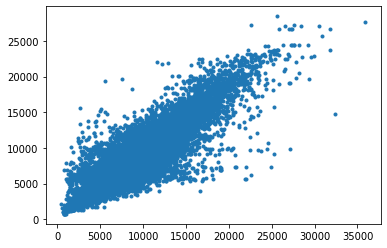

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y_validation, y_pred, '.')
plt.show()

               features    values
0                 Store  0.670567
2                 Promo  0.141681
14            Month_cos  0.044279
15          Weekday_sin  0.032322
16          Weekday_cos  0.031392
7   CompetitionDistance  0.017704
17  SalesCompetitionLag  0.016670
18            Promo2Lag  0.010550
5             StoreType  0.008868
4         SchoolHoliday  0.008541
13            Month_sin  0.008084
6            Assortment  0.003250
12                 Year  0.001155
8                Promo2  0.001150
3          StateHoliday  0.000974
11      PromoInterval_3  0.000764
1                  Open  0.000730
10      PromoInterval_2  0.000714
9       PromoInterval_1  0.000605


<AxesSubplot:ylabel='features'>

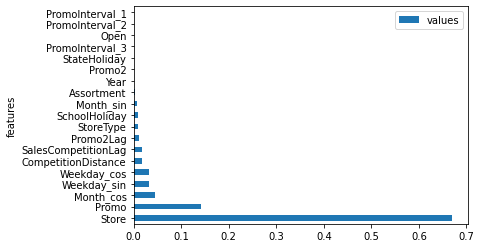

In [40]:
importances = pd.DataFrame({
    "features": rfpipe.steps[3][1].feature_names_in_,
    "values": rfpipe.steps[3][1].feature_importances_,
})

print(importances.sort_values(by="values", ascending=False))

importances.set_index("features").sort_values(by="values", ascending=False).plot.barh()

# Preprocessing of data

## First cleaning

Samples without sales data as well as days that sales are zero can be dropped.

In [7]:
sales_data.dropna(subset=["Sales"], inplace=True)

keep_mask = sales_data.loc[:, "Sales"] != 0
sales_data = sales_data[keep_mask]

We will also drop the customers feature. This feature is directly linked to our target, the sales. Moreover the number of customers in the future is not known, again similar to the sales themselves.

In [8]:
sales_data.drop("Customers", axis=1, inplace=True)

/Users/corstiaen/opt/anaconda3/envs/minicompenv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


After these steps there are still 30 duplicated samples in our dataset. Although these duplicates may actually be real numbers af two shops having the exact same sales on a single day, it is hard to disentangle. Moreover, 30 samples on a dataset of >500,000 is negligible.

In [9]:
duped_mask = sales_data.duplicated()
duplicated_data = sales_data.loc[duped_mask, :]

print(len(duplicated_data))
duplicated_data.head()

30


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
17319,2013-01-16,NaN,3.0,2795.0,1.0,0.0,0,0.0
43383,2013-02-08,NaN,5.0,5706.0,1.0,1.0,0,0.0
79395,2013-03-13,NaN,3.0,4907.0,1.0,0.0,0,0.0
83406,2013-03-16,NaN,6.0,4648.0,1.0,0.0,0,0.0
122096,2013-04-20,NaN,6.0,2890.0,1.0,0.0,0,0.0


In [10]:
sales_data.drop_duplicates(inplace=True)

/Users/corstiaen/opt/anaconda3/envs/minicompenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Merging sales and store data

We need to merge the sales data with the store data. Checking data types reveals that the feature on which we will merge, "Store", is not of the same type. We change the datatype of "Store" in the sales data, such that it matches the store data. We do this step manually here, but this step will also be included in our pipeline.

In [11]:
sales_data.dtypes

Date              object
Store            float64
DayOfWeek        float64
Sales            float64
Open             float64
Promo            float64
StateHoliday      object
SchoolHoliday    float64
dtype: object

In [12]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

There's NaNs in the store ID. We will encode them with 0, because that label does not exist for a store in the store data.

In [13]:
sales_data.isnull().sum()

Date                 0
Store            15550
DayOfWeek        15299
Sales                0
Open             15455
Promo            15439
StateHoliday     15560
SchoolHoliday    15547
dtype: int64

In [14]:
store_data.loc[:, "Store"].min()

1

In [15]:
sales_data = sales_data.fillna({"Store": 0})

In [16]:
sales_data = sales_data.astype({"Store": int})

Actual merging of tables.

In [17]:
merged_data = sales_data.merge(store_data, how="left", on="Store")

In [18]:
print(f"The total number of samples in our dataset is {len(merged_data)}")
merged_data.head()

The total number of samples in our dataset is 512926


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,353,2.0,3139.0,1.0,0.0,a,1.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,2013-01-01,335,2.0,2401.0,1.0,0.0,a,1.0,b,a,90.0,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,2013-01-01,512,2.0,2646.0,1.0,0.0,a,1.0,b,b,590.0,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,2013-01-01,494,2.0,3113.0,1.0,0.0,a,1.0,b,a,1260.0,6.0,2011.0,0.0,NaN,NaN,NaN
4,2013-01-01,530,2.0,2907.0,1.0,0.0,a,1.0,a,c,18160.0,NaN,NaN,0.0,NaN,NaN,NaN


# Splitting train, validation, and test sets

When using tree-based models we can use random splitting of the data:

In [19]:
X = merged_data.loc[:, ~merged_data.columns.isin(["Sales"])]
y = merged_data.loc[:, "Sales"]

X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y,
    random_state=42,
    train_size=.8,
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_valid,
    y_train_valid,
    random_state=42,
    train_size=.8,
)

In [20]:
print(f"Our train set has {len(X_train)} samples")
print(f"Our validation set has {len(X_validation)} samples")
print(f"Our test set has {len(X_test)} samples")
X_train.head()

Our train set has 328272 samples
Our validation set has 82068 samples
Our test set has 102586 samples


,Date,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
143140,2013-06-12,353,3.0,1.0,0.0,0,0.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
494300,2014-07-08,267,2.0,1.0,0.0,0,0.0,c,a,2460.0,1.0,2012.0,0.0,NaN,NaN,NaN
417249,2014-04-08,734,2.0,1.0,0.0,0.0,0.0,a,a,220.0,NaN,NaN,1.0,36.0,2013.0,"Mar,Jun,Sept,Dec"
370025,2014-02-17,0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249373,2013-10-05,510,NaN,1.0,NaN,0,0.0,a,c,8260.0,NaN,NaN,0.0,NaN,NaN,NaN


**When using trend+seasonality based models we need to split the data using a date-cutoff. This may be implemented later.**

# Data profiling

The cell below is commented out for faster running of this notebook. The resulting profile report can be found by following this link:

**[Rossmann profile report](files/rossmann_profile_report.html)**

In [21]:
# profile = ProfileReport(X_train)
# profile.to_file(output_file="rossmann_profile_report.html")

# Feature engineering

### Check amount of features missing per sample. If 4 or more, meaning about 50%, try dropping entire row.

### We also need to look into outliers!

**Lilla**

    Date -> datetime
    split in year, month, week, day of week; drop the original
    make sure weekday matches weekday from date; check for missing values and impute where necessary
    encode all except year with sine+cosine! https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

    DayOfWeek
    drop, replace with values derived from Date

    CompetitionDistance -> float
    Try: median imputation
    Try also: KNNImputer (sklearn)

**Corstiaen**

    Store
    3 options:
    * drop
    * target encoding -> float
    * frequency encoding -> int
    test model to seae what works best
   **MAKE SURE STORE FEATURE IS SAME dTYPE;
   NEEDS 0 IMPUTING FOR THAT**

    Open -> one-hot encode
    3 categories, meaning 2 one-hot columns
    Started with median imputing (1 for True)
    
    Promo -> one-hot encode
    3 categories, meaning 2 one-hot columns
    Started with median imputing (0 for False)
    
    StateHoliday -> one-hot encode
    5 categories, meaning 4 one-hot columns
    turn 0.0 into 0
    ['0', 0.0, 'c', nan, 'a', 'b']
    Started with median imputing (0 for No Holiday)
    
    SchoolHoliday -> one-hot encode
    3 categories, meaning 2 one-hot columns
    Started with median imputing (0 for No Holiday)
    
    StoreType -> label encode
    Try label encoding first
    Potentially try 5 categories, meaning 4 one-hot columns
    Started with mode imputing
    
    Assortment -> label encode
    Try label encoding first
    Potentially try 4 categories, meaning 3 one-hot columns
    Started with mode imputing
    
    
**SAM**

    CompetitionOpenSinceMonth -> new int or float
    CompetitionOpenSinceYear -> new int or float
    Merge and create new feature, giving temporal distance from 2015-07-31 or 2015-08-31
    potentially use datetime for these calculations?
    Try: median imputation
    Try also: KNNImputer (sklearn)
    
    Promo2 -> one-hot encode
    3 categories including NaN, 2 columns
    make sure all missing in other Promo2 features are described by these three categories!
    
    Promo2SinceWeek -> new int or float
    Promo2SinceYear -> new int or float
    Merge and create new feature, giving temporal distance from 2015-07-31 or 2015-08-31
    potentially use datetime for these calculations?
    imputation with any value, this is caught by the boolean from Promo2 feature
    
    PromoInterval -> one-hot encode
    3 categories, NaNs can be added to the mode category, these will again be described by the Promo2 feature
    

### Imputing

**ATTENTION: After dropping all days with Sales=0, we only have days left where the store was opened, or where it was not known! Therefore changing NaNs for that feature to 0. We may completely delete the column later.**